In [1]:
# importing all the libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import ImageGrid
import copy
import random
import pandas as pd
import math
import scipy
from scipy.stats import norm, expon
from scipy.linalg import null_space
import pandas as pd
import matplotlib as mpl

import os
cwd = os.getcwd()

In [2]:
# define variables
data_seed = 1223
burnin = 10000 #10k
n_after_burnin = 10000 #10k
delta_t = 0.3

#T=60 gives 200 delta_y
T = 120
n_data = 400
n_chains = 4
n_sim = 1

V_F = 2000
V_B = -1500
V = np.array([V_F, V_B])
Lambda = np.array([1, 0.5, 2, 0.15])
log_Lambda = np.log(Lambda)
P = np.array([[0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 1.0, 0.0],
              [0.25, 0.25, 0.0, 0.5],
              [0.0, 0.0, 1.0, 0.0]])
sigma = 50.0
n_param = {'4twoS_to_3':7, '4twoS_to_4twoS':9}

correlated = True
up_to_switches = 1
track = True

plots = False
save = True
all_plots = False
plot_posteriors_grid = False
plot_fit = False
plot_fit_median = False

In [3]:
theta_true = {'4twoS_to_3':[2000, -1500, np.log(1.0), np.log(0.5), np.log(0.15), 0.5, 50], 
              '4twoS_to_4twoS':[2000, -1500, np.log(1.0), np.log(0.5), np.log(2),
                                np.log(0.15), 0.25, 0.25, 50]}

In [4]:
list_of_folders = ['4twoS_to_3', '4twoS_to_4twoS']

parameter_names = {'4twoS_to_3':['v1', 'v2', 'log(lambda1)', 'log(lambda2)',
                                   'log(lambda3)', 'p31', 'sigma'],
                   '4twoS_to_4twoS':['v1', 'v2', 'log(lambda1)', 'log(lambda2)',
                                     'log(lambda3)', 'log(lambda4)', 
                                     'p31', 'p32', 'sigma']}

parameter_names_tex = {'4twoS_to_3':[r'$v_1$', r'$v_2$', r'log$(\lambda_1)$',
                                     r'log$(\lambda_2)$', r'log$(\lambda_3)$',
                                     r'$p_{31}$', r'$\sigma$'], 
                       '4twoS_to_4twoS':[r'$v_1$', r'$v_2$', r'log$(\lambda_1)$',
                                         r'log$(\lambda_2)$', r'log$(\lambda_3)$',
                                         r'log$(\lambda_4)$',  
                                         r'$p_{31}$', r'$p_{32}$',
                                         r'$\sigma$']}

In [5]:
#importing the log_pi results of the inference
#this can take a while
#seed number is printed as they get imported
log_pi = {'4twoS_to_3':[None for _ in range(100)],
          '4twoS_to_4twoS':[None for _ in range(100)]}

#the four-state model with data using seed 57 was taking a long time to converge
#so we used seeds [0,...,56] and [58,...,100]
#seed 89 was also taking a long time, but converged using parallel chains
for fold_name in list_of_folders:
    print("Importing logpi - folder", fold_name, "seed")
    for seed in list(range(57))+list(range(58,101)):
        print(str(seed))
        seed1 = seed-seed//58
        log_pi[fold_name][seed1] = np.array(pd.read_csv("RESULTS_"+fold_name+"_pij/MCMC, seed "+str(seed)+", log_pi , burnin=1000, n_after_burnin=10000", index_col=0)).flatten()

Importing logpi - folder 4twoS_to_3 seed
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
Importing logpi - folder 4twoS_to_4twoS seed
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [6]:
#Computing the AIC and the BIC
#AIC = 2k - 2log(maxL)
AICs = [[], []]

for fold_ind in range(2):
    fold_name = list_of_folders[fold_ind]
    AICs[fold_ind] = [2*n_param[fold_name]-np.max(log_pi[fold_name][seed])
                       for seed in range(100)]

AICs = np.array(AICs)

AIC_choice = np.zeros(2)
for seed in range(100):
    AIC_choice[np.argmin([AICs[i, seed] for i in range(2)])] += 0.01
    
    

#{BIC} = k log(N) - 2log(maxL)
BICs = [[], []]

for fold_ind in range(2):
    fold_name = list_of_folders[fold_ind]
    BICs[fold_ind] = [n_param[fold_name]*np.log(n_data)-np.max(log_pi[fold_name][seed])
                       for seed in range(100)]

BICs = np.array(BICs)

BIC_choice = np.zeros(2)
for seed in range(100):
    BIC_choice[np.argmin([BICs[i, seed] for i in range(2)])] += 0.01

AIC choice [0.42 0.58]
BIC choice [0.94 0.06]


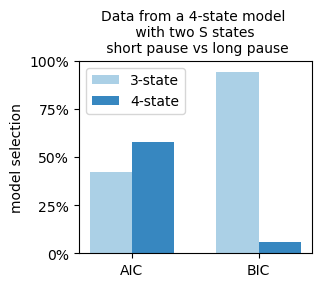

In [13]:
#Figure 6 panel F
print('AIC choice', AIC_choice)
print('BIC choice', BIC_choice)

colors_list = mpl.colormaps['Blues'](np.linspace(0, 1, 4))[1:3]
positions = [-0.2,0.2]
model_names = ['3-state', '4-state']

plt.figure(figsize=(3,2.5))

for i in range(2):
    j = positions[i]
    plt.bar(j, AIC_choice[i]*100, width=0.4,
            label=model_names[i], color=colors_list[i])

plt.legend()

for i in range(2):
    j = positions[i]
    plt.bar(j+1.2, BIC_choice[i]*100, width=0.4,
            label=model_names[i], color=colors_list[i])

plt.xticks([0,1.2], ['AIC', 'BIC'])
plt.yticks([0,25,50,75,100],['0%','25%','50%','75%','100%'])
#plt.ylabel(r"model selected using $\hat P_1$")
plt.title('Data from a 4-state model \n with two S states \n short pause vs long pause',
          fontsize=10)
plt.ylabel('model selection', fontsize=10)
plt.savefig("frequency_model_selected_with_criteria_4twoS_vs_3.png", format="png", dpi=1200,
            bbox_inches="tight")
plt.show()

In [10]:
theta_all = {'4twoS_to_3':[[] for _ in range(100)], '4twoS_to_4twoS':[[] for _ in range(100)]}
theta_best = {'4twoS_to_3':[None for _ in range(100)], '4twoS_to_4twoS':[None for _ in range(100)]}

#importing the data - this does take a while
for fold_name in list_of_folders:
    print("Importing theta - folder", fold_name, "seed")
    for seed in list(range(57))+list(range(58,101)):
        seed1 = seed-seed//58
        print(str(seed))
        for param in parameter_names[fold_name]:
            theta_all[fold_name][seed1] += [np.array(pd.read_csv("RESULTS_"+fold_name+"_pij/MCMC, seed "+str(seed)+", parameter "+param+", burnin=1000, n_after_burnin=10000", index_col=0)).flatten()]
        theta_all[fold_name][seed1] = np.array(theta_all[fold_name][seed1])
        theta_best[fold_name][seed1] = theta_all[fold_name][seed1][:, np.argmax(log_pi[fold_name][seed1])]

Importing theta - folder 4twoS_to_3 seed
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
Importing theta - folder 4twoS_to_4twoS seed
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


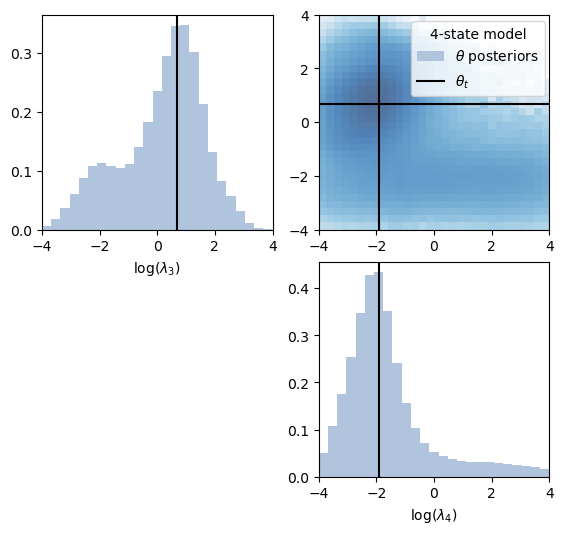

In [10]:
#Figure 7 panel B

priors = {'4twoS_to_4twoS':[[2.0*1300, 2.0*V_F], [2.0*V_B, 0.0],
                            [-4.0, 4.0], [-4.0, 4.0],
                          [-4.0, 4.0], [-4.0, 4.0], [0, 1], [0, 1], [0.0, 2.0*sigma]],
          '4twoS_to_3':[[0.0, 2.0*V_F], [2.0*V_B, 0.0], [-4.0, 4.0], [-4.0, 4.0],
                          [-4.0, 4.0], [0, 1], [0.0, 2.0*sigma]]}

for fold_name in ['4twoS_to_4twoS']:

    fig, ax = plt.subplots(2, 2,
                           figsize=(7,6))
    plt.subplots_adjust(wspace=0.2, hspace=0.15)
    for i in [4,5]:
        ax[i-4,i-4].set_xlabel(parameter_names_tex[fold_name][i])

    for i in [4,5]:
        ax[i-4,i-4].hist(np.array([theta_all[fold_name][seed][i]
                                   for seed in range(100)]).flatten(),
                         bins=25, alpha=1.0, density=True,
                         label=r'$\theta$ posteriors', color='lightsteelblue')
        ax[i-4,i-4].axvline(theta_true[fold_name][i], color='black',
                        label=r'$\theta_t$')
        
        ax[i-4,i-4].set_xlim(priors[fold_name][i])

    for i in [4,5]:
        for j in range(4,i):
            ax[i-4,j-4].axis('off')
        for j in range(i+1,6):
            #plt.title('Checking correlations')
            ax[i-4,j-4].hist2d(np.array([theta_all[fold_name][seed][j]
                                   for seed in range(100)]).flatten(),
                           np.array([theta_all[fold_name][seed][i]
                                   for seed in range(100)]).flatten(), density=True, bins=30,
                           norm=colors.LogNorm(), alpha=0.7, cmap='Blues')
            
            ax[i-4,j-4].set_xlim(priors[fold_name][j])
            ax[i-4,j-4].set_ylim(priors[fold_name][i])

            ax[i-4,j-4].axvline(theta_true[fold_name][j], color='black')
            ax[i-4,j-4].axhline(theta_true[fold_name][i], color='black')
    plt.subplots_adjust(right=0.85)
    plt.legend(title='4-state model', bbox_to_anchor=(0.98, 2.12), loc='upper right', borderaxespad=0)
    plt.savefig("compare_lambda_3_4_posteriors_with_priors_"+fold_name+".png", format="png", dpi=1200, bbox_inches="tight")
    plt.show()

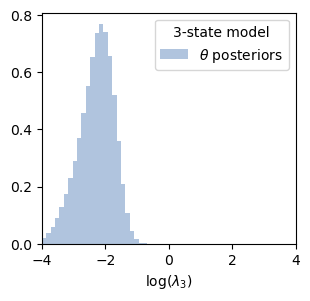

In [11]:
#Figure 7 panel D
for fold_name in ['4twoS_to_3']:

    fig, ax = plt.subplots(figsize=(3.5,3))
    plt.subplots_adjust(wspace=0.35, hspace=0.2)
    for i in [4]:
        #ax.set_ylabel(parameter_names_tex[fold_name][i])
        ax.set_xlabel(parameter_names_tex[fold_name][i])
        
        ax.set_xlim(priors[fold_name][i])

    for i in [4]:
        ax.hist(np.array([theta_all[fold_name][seed][i]
                                   for seed in range(100)]).flatten(),
                bins=25, alpha=1.0, density=True,
                label=r'$\theta$ posteriors', color='lightsteelblue')
        
    plt.subplots_adjust(right=0.85)
    plt.legend(title='3-state model', loc='upper right')
    plt.savefig("compare_lambda_3_4_posteriors_with_priors_"+fold_name+".png", format="png", dpi=1200, bbox_inches="tight")
    plt.show()

2 42
1 52
0 6


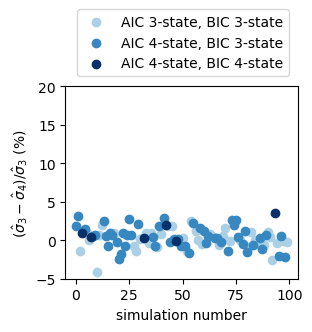

In [17]:
aic3 = []
bic3 = []
noise_red = []
indeces = np.zeros(100)
split_list = [[], [], []]
colors =  mpl.colormaps['Blues'](np.linspace(0, 1, 4))[3:0:-1]
labels = ['AIC 4-state, BIC 4-state', 'AIC 4-state, BIC 3-state',
          'AIC 3-state, BIC 3-state']
plt.figure(figsize=(3,2.5))
for seed in range(100):
    #print('\n')
    #print(seed)
    aic3 += [AICs[0, seed]<AICs[1, seed]]
    #print("AIC choice 3-state", aic3[seed])
    if aic3[seed]:
        indeces[seed] +=1
    bic3 += [BICs[0, seed]<BICs[1, seed]]
    #print("BIC choice 3-state", bic3[seed])
    if bic3[seed]:
        indeces[seed] +=1
    split_list[int(indeces[seed])] += [int(seed)]
    #print("AGREE", aic3[seed]==bic3[seed])
    noise_red += [((theta_best['4twoS_to_3'][seed][-1]-theta_best['4twoS_to_4twoS'][seed][-1])
                  /theta_best['4twoS_to_3'][seed][-1]*100)]
    #print(noise_red[seed], "%")
for ind in [2,1,0]:
    print(ind, len(split_list[ind]))
    plt.scatter(split_list[ind], [noise_red[i] for i in split_list[ind]],
                color=colors[ind], label=labels[ind])
plt.ylabel(r'$(\hat\sigma_3-\hat\sigma_4)/\hat\sigma_3$ (%)')
plt.xlabel('simulation number')
plt.ylim([-5,20])
plt.legend(bbox_to_anchor=(0.05, 1.4), loc='upper left', borderaxespad=0)
plt.savefig("noise_reduction_4twoS_vs_3.png", format="png", dpi=1200,
            bbox_inches="tight")
plt.show()